In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import timedelta
import numpy as np
from sklearn.cross_validation import train_test_split,ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, regression
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.learning_curve import learning_curve

import warnings
warnings.filterwarnings('ignore')

#### Downloading the NYC Taxi and Limousine trip record data for GREEN TAXIS for September 2015.

In [4]:
trip_data=pd.read_csv('https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv')
trip_data.head()

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,Fare_amount,Extra,MTA_tax,Tip_amount,Tolls_amount,Ehail_fee,improvement_surcharge,Total_amount,Payment_type,Trip_type
0,2,2015-09-01 00:02:34,2015-09-01 00:02:38,N,5,-73.979485,40.684956,-73.979431,40.685020,1,...,7.8,0.0,0.0,1.95,0.0,NaN,0.0,9.75,1,2.0
1,2,2015-09-01 00:04:20,2015-09-01 00:04:24,N,5,-74.010796,40.912216,-74.010780,40.912212,1,...,45.0,0.0,0.0,0.00,0.0,NaN,0.0,45.00,1,2.0
2,2,2015-09-01 00:01:50,2015-09-01 00:04:24,N,1,-73.921410,40.766708,-73.914413,40.764687,1,...,4.0,0.5,0.5,0.50,0.0,NaN,0.3,5.80,1,1.0
3,2,2015-09-01 00:02:36,2015-09-01 00:06:42,N,1,-73.921387,40.766678,-73.931427,40.771584,1,...,5.0,0.5,0.5,0.00,0.0,NaN,0.3,6.30,2,1.0
4,2,2015-09-01 00:00:14,2015-09-01 00:04:20,N,1,-73.955482,40.714046,-73.944412,40.714729,1,...,5.0,0.5,0.5,0.00,0.0,NaN,0.3,6.30,2,1.0


#### Reporting number of rows and columns loaded

In [308]:
print(trip_data.shape)
print("Number of rows loaded: ",trip_data.shape[0])
print("Number of columns loaded: ",trip_data.shape[1])

(1494926, 21)
Number of rows loaded:  1494926
Number of columns loaded:  21


In [9]:
trip_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1494926 entries, 0 to 1494925
Data columns (total 21 columns):
VendorID                 1494926 non-null int64
lpep_pickup_datetime     1494926 non-null object
Lpep_dropoff_datetime    1494926 non-null object
Store_and_fwd_flag       1494926 non-null object
RateCodeID               1494926 non-null int64
Pickup_longitude         1494926 non-null float64
Pickup_latitude          1494926 non-null float64
Dropoff_longitude        1494926 non-null float64
Dropoff_latitude         1494926 non-null float64
Passenger_count          1494926 non-null int64
Trip_distance            1494926 non-null float64
Fare_amount              1494926 non-null float64
Extra                    1494926 non-null float64
MTA_tax                  1494926 non-null float64
Tip_amount               1494926 non-null float64
Tolls_amount             1494926 non-null float64
Ehail_fee                0 non-null float64
improvement_surcharge    1494926 non-null float64
To

In [310]:
trip_data.describe()['Trip_distance']

count    1.494926e+06
mean     2.968141e+00
std      3.076621e+00
min      0.000000e+00
25%      1.100000e+00
50%      1.980000e+00
75%      3.740000e+00
max      6.031000e+02
Name: Trip_distance, dtype: float64

Text(0.5,1,'Histogram of the number of Trip Distance(Without Tranformation)')

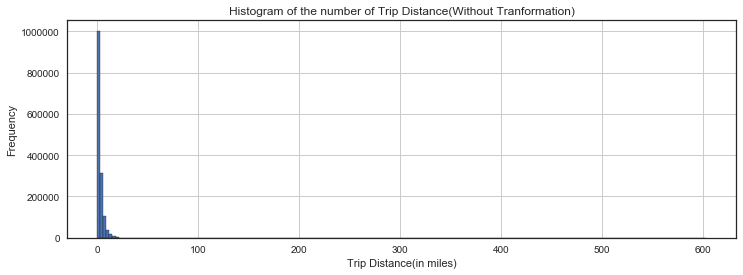

In [8]:
sns.set()
plt.style.use('seaborn-white')
trip_data['Trip_distance'].hist(bins=200,edgecolor='black',figsize=(12,4))
plt.xlabel('Trip Distance(in miles)')
plt.ylabel('Frequency')
plt.title('Histogram of the number of Trip Distance(Without Tranformation)')

#### Plotting the histogram of Trip_distance we observe that the data is highly skewed.  Taking log transformation will make our skewed data conform to normality

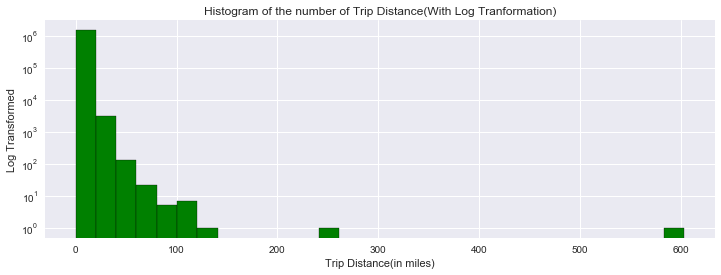

In [313]:
sns.set()
plt.yscale('log')
trip_data['Trip_distance'].hist(bins=30,color='green',edgecolor='black',figsize=(12,4))
plt.xlabel('Trip Distance(in miles)')
plt.ylabel('Log Transformed')
plt.title('Histogram of the number of Trip Distance(With Log Tranformation)')
plt.show()

#### We observe that the log(Trip_distance) is skewed to the right. Most people travel 0-150 miles. However there are a few outliers who have travelled 250-280 miles and about 600 miles. To confirm the findings, Univariate Analysis using boxplots has been conducted.

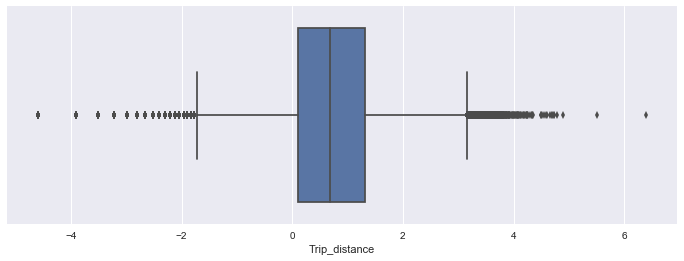

In [314]:
sns.set()
plt.figure(figsize=(12,4))
sns.boxplot(x=np.log(trip_data.Trip_distance))
plt.show()

##### We use the Z score to describe our data points by finding the relationship with their standard deviation and mean of the group of points. While calculating the Z-score we re-scale(The mean is 0 and standard deviation is 1) and center the data and look for data points which are too far from zero. These data points which are way too far from zero will be treated as the outliers. Zscore doesn't tell us which data point is an outlier. So we define a threshold of 3 to identify outliers.

In [315]:
z=np.abs(stats.zscore(trip_data.Trip_distance))
threshold=3
trip_data_wo=trip_data[(z<3)]
print('Number of outliers removed:',trip_data.shape[0]-trip_data_wo.shape[0])

Number of outliers removed: 29192


##### After removing the outliers, right skewed distibution due to lower bound of 0 on the Trip_distance has been obtained. We observe that most rides are short rides with most of them bein 1-2 miles long.

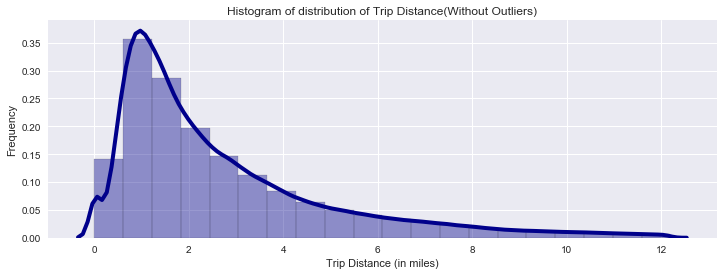

In [317]:
sns.set()
plt.figure(figsize=(12,4))
ax=sns.distplot(trip_data_wo['Trip_distance'], hist=True, kde=True, 
             bins=20, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax.set_xlabel('Trip Distance (in miles)')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of distribution of Trip Distance(Without Outliers)')
plt.show()

In [318]:
pickup_list=trip_data['lpep_pickup_datetime']
trip_data['Pickup_Hour']=trip_data['lpep_pickup_datetime'].apply(lambda t:pd.to_datetime(t).hour)
Mean_Pickup_Hour=trip_data.groupby('Pickup_Hour')['Trip_distance'].mean()
Median_Pickup_Hour=trip_data.groupby('Pickup_Hour')['Trip_distance'].median()
report=pd.DataFrame({'Pickup Hour':trip_data['Pickup_Hour'].unique(),'Mean':Mean_Pickup_Hour,'Median':Median_Pickup_Hour})
report.set_index('Pickup Hour',inplace=True)
report

,Mean,Median
Pickup Hour,,
0,3.115276,2.20
1,3.017347,2.12
2,3.046176,2.14
3,3.212945,2.20
4,3.526555,2.36
5,4.133474,2.90
6,4.055149,2.84
7,3.284394,2.17
8,3.048450,1.98


#### It is observed that between 5 AM to 6 AM larger distances are travelled as compared to other hours of day

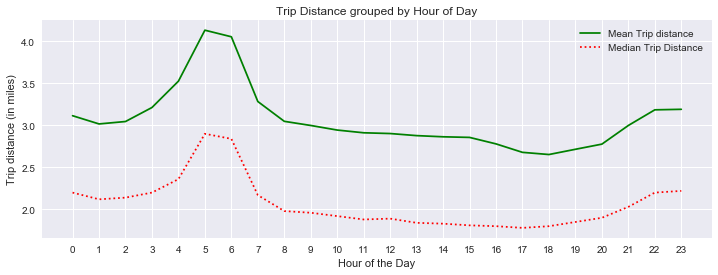

In [319]:
%matplotlib inline
sns.set()
plt.figure(figsize=(12,4))
plt.plot(trip_data['Pickup_Hour'].unique(),Mean_Pickup_Hour,'-g',label='Mean Trip distance')
plt.plot(trip_data['Pickup_Hour'].unique(),Median_Pickup_Hour,':r',label='Median Trip Distance')
plt.xlabel('Hour of the Day')
plt.ylabel('Trip distance (in miles)')
plt.xticks(np.arange(0,24,step=1))
plt.title('Trip Distance grouped by Hour of Day')
plt.legend()
plt.show()

#### Using the haversine-formula to calculate distance in miles between 2 points

In [320]:
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

#### The function airport_location is used to check trips that originate/terminate from within 1 mile of Newyork airports. The range parameter can be changed as per requirement

In [321]:
jfk = (-73.7781391, 40.6413111)
nyc = (-74.1744624, 40.6895314)

airport_trips=[]
def airport_location(loc,range=1):
    #Selecting all data points with pick up/drop off location within range of 1 mile from airport.
    for index,row in trip_data.iterrows():
        if((distance(row['Pickup_latitude'],row['Pickup_longitude'],loc[1],loc[0])<range)
           |(distance(row['Dropoff_latitude'],row['Dropoff_longitude'],loc[1],loc[0])<range)):
            airport_trips.append(row)
            
            

airport_location(jfk)
airport_location(nyc)
air=pd.DataFrame(airport_trips)

print('Number of trips that originate/terminate at JFK/NYC airports are: ',air.shape[0])
print('The average fare of trips that originate/terminate at JFK/NYC airports is: ',air['Total_amount'].mean())

Number of trips that originate/terminate at JFK/NYC airports are:  13647
The average fare of trips that originate/terminate at JFK/NYC airports is:  51.23473290833322


#### Some characteristics about the Airport Trips: From data dictionary, we can observe that RateCodeID is the rate code in effect at the end of the trip.JFK and Newark airports have RateCodeID 2 and 3 respectively. This can also be used to find trips that originate or terminate at airport. The mean trip_distance and Total_amount has been calculated for each hour of day for airport trips.

In [322]:
airport_trip=trip_data[(trip_data['RateCodeID']==2)|(trip_data['RateCodeID']==3)]
airport_data=airport_trip[['Pickup_Hour','Trip_distance','Total_amount']]
airport_data=airport_data.groupby('Pickup_Hour',as_index=False)
airport_data=airport_data.aggregate(np.mean)
airport_data

,Pickup_Hour,Trip_distance,Total_amount
0,0,1.777941,44.550000
1,1,2.401481,38.122840
2,2,3.909104,46.665821
3,3,9.142353,55.993294
4,4,11.449433,56.266950
5,5,14.875976,63.720427
6,6,14.902872,63.825282
7,7,12.712581,60.500737
8,8,13.070323,62.088347
9,9,10.530510,57.141294


#### From these plots, 2 interesting observations can be made: 1) Most airport trips are made between 4-5 in the morning and 2-4 in the afternoon.  2)The total amount earned does not vary as drastically with hour of the day, as it does in case of distance. This could imply that there is a certain FIXED CHARGE for airport trips.

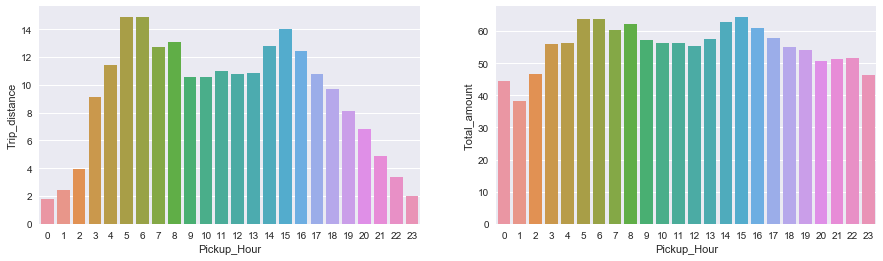

In [350]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
sns.barplot(x='Pickup_Hour', y='Trip_distance', data=airport_data)
plt.subplot(1,2,2)
sns.barplot(x='Pickup_Hour', y='Total_amount', data=airport_data)
plt.show()

#### Plotting mean of distance grouped by day of week, it is observed that there is a drastic decrease in distance covered from Monday to Tuesday, one of the reasons could be that people make airport visits during weekends and return back home usually on Monday. Also, the fare for these trips is the maximum.

In [328]:
#0-Monday, 1-Tuesday, 2-Wednesday,3-Thursday,4-Friday,5-Saturday,6-Sunday
trip_data['Day_of_Week']=trip_data['lpep_pickup_datetime'].apply(lambda t:(pd.to_datetime(t).day)%7)
air_day=trip_data[(trip_data['RateCodeID']==2)|(trip_data['RateCodeID']==3)]
air_day=air_day[['Day_of_Week','Trip_distance','Total_amount']]
air_day=air_day.groupby('Day_of_Week',as_index=False)
air_day=air_day.aggregate(np.mean)
air_day

,Day_of_Week,Trip_distance,Total_amount
0,0,11.437840,59.991802
1,1,10.221351,56.501686
2,2,10.318535,56.852326
3,3,10.688663,57.849763
4,4,10.361648,56.967398
5,5,9.997817,56.756655
6,6,9.725813,55.810556


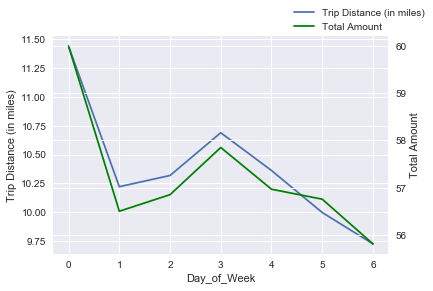

In [329]:
ax = air_day.plot(x="Day_of_Week", y="Trip_distance", legend=False,label='Trip Distance (in miles)')
ax.set_ylabel('Trip Distance (in miles)')
ax2 = ax.twinx()
ax2.set_ylabel('Total Amount')
air_day.plot(x="Day_of_Week", y="Total_amount", ax=ax2, legend=False, color="g",label='Total Amount')
ax.figure.legend()
plt.show()

#### Creating a derived variable for tip as a percentage of total fare

In [330]:
trip_data['Tip_percent']=(trip_data['Tip_amount']/trip_data['Total_amount'])*100
trip_data['Tip_percent'].dropna(axis=0,inplace=True)
trip_data.head()

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,Tip_amount,Tolls_amount,Ehail_fee,improvement_surcharge,Total_amount,Payment_type,Trip_type,Pickup_Hour,Day_of_Week,Tip_percent
0,2,2015-09-01 00:02:34,2015-09-01 00:02:38,N,5,-73.979485,40.684956,-73.979431,40.685020,1,...,1.95,0.0,NaN,0.0,9.75,1,2.0,0,1,20.00000
1,2,2015-09-01 00:04:20,2015-09-01 00:04:24,N,5,-74.010796,40.912216,-74.010780,40.912212,1,...,0.00,0.0,NaN,0.0,45.00,1,2.0,0,1,0.00000
2,2,2015-09-01 00:01:50,2015-09-01 00:04:24,N,1,-73.921410,40.766708,-73.914413,40.764687,1,...,0.50,0.0,NaN,0.3,5.80,1,1.0,0,1,8.62069
3,2,2015-09-01 00:02:36,2015-09-01 00:06:42,N,1,-73.921387,40.766678,-73.931427,40.771584,1,...,0.00,0.0,NaN,0.3,6.30,2,1.0,0,1,0.00000
4,2,2015-09-01 00:00:14,2015-09-01 00:04:20,N,1,-73.955482,40.714046,-73.944412,40.714729,1,...,0.00,0.0,NaN,0.3,6.30,2,1.0,0,1,0.00000


#### Data Cleaning:

In [331]:
if 'Ehail_fee' in trip_data.columns:
    trip_data.drop(['Ehail_fee'],axis=1,inplace=True)

# Removing rows which have NA values as 'Tip_percent'
trip_data['Tip_percent'].dropna(axis=0,inplace=True)

#We remove transactions done through cash mode, as only credit card(Payment_Type=1) tips are recorded
trip_data=trip_data[trip_data['Payment_type']==1]

#Checking for values of Tip_percent which are less than 0 and greater than 100
trip_data=trip_data.drop(trip_data[(trip_data['Tip_percent']<0)|(trip_data['Tip_percent']>100)].index)

#Removing data points having 0 or negative bill amount
trip_data=trip_data.drop(trip_data[trip_data['Total_amount']<=0].index)

#Removing data points having 0 as latitude/longitude for pickup/dropoff location 
trip_data=trip_data.drop(trip_data[(trip_data['Pickup_longitude']==0)|(trip_data['Pickup_longitude']==0)
                         |(trip_data['Pickup_longitude']==0)|(trip_data['Pickup_longitude']==0)].index)

#Trips with 0 distance will not contribute to our model, so we remove them
trip_data.drop(trip_data[trip_data['Trip_distance']==0].index,axis=0,inplace=True)

#We will now drop these missing values from our model.
trip_data.drop(trip_data[trip_data.isnull().any(1)].index,axis=0,inplace=True)

#Checking for missing values after performing data cleaning-
trip_data.isnull().sum().sort_values()

VendorID                 0
Pickup_Hour              0
Trip_type                0
Payment_type             0
Total_amount             0
improvement_surcharge    0
Tolls_amount             0
Tip_amount               0
MTA_tax                  0
Extra                    0
Day_of_Week              0
Fare_amount              0
Passenger_count          0
Dropoff_latitude         0
Dropoff_longitude        0
Pickup_latitude          0
Pickup_longitude         0
RateCodeID               0
Store_and_fwd_flag       0
Lpep_dropoff_datetime    0
lpep_pickup_datetime     0
Trip_distance            0
Tip_percent              0
dtype: int64

#### Data Exploration:

#### From people who paid via credit card,most of commutes pay a tip of 16-18%. Almost no one tips over 32%

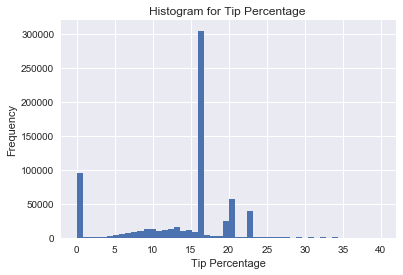

In [332]:
plt.hist(trip_data['Tip_percent'],bins=50,range=[0,40])
plt.xlabel('Tip Percentage')
plt.ylabel('Frequency')
plt.title('Histogram for Tip Percentage ')
plt.show()

#### Feature Engineering:

In [333]:
#Engineering 'Dropoff_Hour'
trip_data['Dropoff_Hour']=trip_data['Lpep_dropoff_datetime'].apply(lambda t:pd.to_datetime(t).hour)

#Engineering feature- 'Trip_Duration'
pickuptime=trip_data['lpep_pickup_datetime'].apply(lambda t:pd.to_datetime(t))
dropofftime=trip_data['Lpep_dropoff_datetime'].apply(lambda t:pd.to_datetime(t))
trip_data['Trip_Duration']=(dropofftime-pickuptime)/timedelta(hours=1)
trip_data.drop(trip_data[trip_data['Trip_Duration']==0].index,inplace=True)

#Engineering feature 'Speed' which is TotalDistance/Total Time
trip_data['Speed']=trip_data['Trip_distance']/(trip_data['Trip_Duration'])
trip_data.replace([np.inf, -np.inf], np.nan)
trip_data['Speed'].fillna(value=0,inplace=True)
trip_data.head()

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,improvement_surcharge,Total_amount,Payment_type,Trip_type,Pickup_Hour,Day_of_Week,Tip_percent,Dropoff_Hour,Trip_Duration,Speed
2,2,2015-09-01 00:01:50,2015-09-01 00:04:24,N,1,-73.921410,40.766708,-73.914413,40.764687,1,...,0.3,5.80,1,1.0,0,1,8.620690,0,0.042778,13.792208
5,2,2015-09-01 00:00:39,2015-09-01 00:05:20,N,1,-73.945297,40.808186,-73.937668,40.821198,1,...,0.3,8.16,1,1.0,0,1,16.666667,0,0.078056,13.708185
6,2,2015-09-01 00:00:52,2015-09-01 00:05:50,N,1,-73.890877,40.746426,-73.876923,40.756306,1,...,0.3,7.80,1,1.0,0,1,0.000000,0,0.082778,17.275168
8,2,2015-09-01 00:02:36,2015-09-01 00:07:20,N,1,-73.963150,40.693829,-73.956787,40.680531,1,...,0.3,8.76,1,1.0,0,1,16.666667,0,0.078889,16.859155
11,2,2015-09-01 00:04:00,2015-09-01 00:06:06,N,1,-73.905540,40.772526,-73.895363,40.768963,1,...,0.3,6.36,1,1.0,0,1,16.666667,0,0.035000,20.000000


#### Feature Selection:

In [334]:
tip_model_response=trip_data.filter(['VendorID','Trip_type ','Trip_distance','Trip_Duration','Total_amount','Speed'],axis=1)
tip_model_target=trip_data['Tip_percent']

,Trip_distance,Trip_Duration,Total_amount,Speed
Trip_distance,1.000000,0.095734,0.918729,0.060719
Trip_Duration,0.095734,1.000000,0.100338,-0.005078
Total_amount,0.918729,0.100338,1.000000,0.019417
Speed,0.060719,-0.005078,0.019417,1.000000


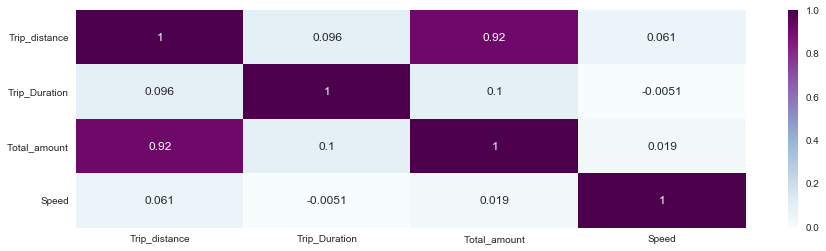

In [335]:
#We shall now see how each dependent variable correlates with each other
tip_model_corr=tip_model_response.filter(['Trip_distance','Trip_Duration','Total_amount','Speed'],axis=1)
def show_correlations(dataframe, show_chart = True):
    fig = plt.figure(figsize = (15,4))
    corr = dataframe.corr()
    if show_chart == True:
        sns.heatmap(corr, 
                    xticklabels=corr.columns.values,
                    yticklabels=corr.columns.values,
                    annot=True,cmap='BuPu')
    return corr

show_correlations(tip_model_corr,show_chart=True)
#We find a strong positive correlation (0.92) between Trip_Distance and Total_Amount, which is expeceted

#### Now, relationship between each predictor variable and target variable('Tip_percent') is visualised to find linear association between them

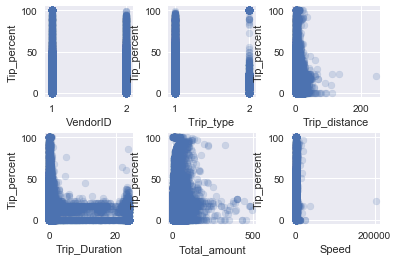

In [336]:
sns.set()
i=1
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for col in tip_model_response:
    ax = fig.add_subplot(2, 3, i)
    plt.xlabel(col)
    plt.ylabel('Tip_percent')
    plt.scatter(tip_model_response[col],tip_model_target,alpha=0.2,cmap='viridis')
    i=i+1


#### Data Modeling:

#### A] Linear Regression(Using Statsmodel.api) 

In [337]:
model = sm.OLS(tip_model_target,tip_model_response).fit()
predictions = model.predict(tip_model_response)
print('Root Mean Squared Error: ',np.sqrt(model.mse_resid))

Root Mean Squared Error:  7.314670047141311


In [338]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Tip_percent   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                 4.369e+05
Date:                Fri, 16 Nov 2018   Prob (F-statistic):               0.00
Time:                        16:17:59   Log-Likelihood:            -2.3585e+06
No. Observations:              691893   AIC:                         4.717e+06
Df Residuals:                  691887   BIC:                         4.717e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
VendorID          1.1606      0.020     58.072      0.000       1.121       1.200
Trip_type         9.3343      0.039    238.979      0.000       9.258       9.411
Trip_distance    -1.6769      0.007   -243.120      0.000      -1.690      -1.663
Trip_Duration    -0.2518      0.006    -43.248      0.000      -0.263      -0.240
Total_amount      0.4660      0.002    254.079      0.000       0.462       0.470
Speed             0.0012   3.28e-05     37.085      0.000       0.001       0.001
==============================================================================
Omnibus:                   189960.325   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         10883796.149
Skew:                          -0.483   Prob(JB):                         0.00
Kurtosis:                      22.406   Cond. No.                     1.33e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.33e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
#### The code for Linear Regression using sklearn has been commented because it gives a low R2 of 0.1140. 
#Requires more time to nderstand why less R2 for Linear model but more for statsmodel.api 

In [293]:
# #Linear Regression(Using Sklearn: Linearmodel)
# X_train,X_test,Y_train,Y_test=train_test_split(tip_model_response,tip_model_target,test_size=0.2,random_state=0)
# regressor=LinearRegression()
# regressor.fit(X_train,Y_train)
# #Calculating R-square:
# y_pred=regressor.predict(X_test)
# print('Linear Regression Model R-Squared: ',regressor.score(X_test,Y_test))
# mse=mean_squared_error(y_pred,Y_test)
# print('Linear Regression RMSE: ',np.sqrt(mse))
# regressor.fit(tip_model_response,tip_model_target)
# regressor.score(tip_model_response,tip_model_target)

Linear Regression Model R-Squared:  0.11404901520339139
Linear Regression RMSE:  6.913090987311159


0.1286809537255783

#### B] Random Forest Regression

In [294]:
#Feature Scaling:
#As every variable has different scale, we need to scale our dataset
sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  
X_test = sc.transform(X_test) 

In [295]:
#Training the Algorithm
regressor=RandomForestRegressor(n_estimators=200,random_state=0)
regressor.fit(X_train,Y_train)
y_pred=regressor.predict(X_test)

In [296]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test,y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_test,y_pred)) 
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test,y_pred)))
print('R2 :',metrics.r2_score(Y_test, y_pred))

Mean Absolute Error: 1.2949306243421164
Mean Squared Error: 10.054465940913431
Root Mean Squared Error: 3.17087778712984
R2 : 0.8136093354866634


In [297]:
print('Feature Importance: ',regressor.feature_importances_)

Feature Importance:  [0.01147868 0.02206253 0.19021152 0.22097832 0.50317904 0.05208991]


In [ ]:
#Considering scale of Percent_Tip from 0-100, an error of 3.2% is permittable.
#We get RMSE=3.62% when number of estimators is 20. 
#We get RMSE= 3.17% when number of estimators is 200

#### C] Gradient Boosted Decision Trees

In [298]:
gbrt=GradientBoostingRegressor(n_estimators=100)
gbrt.fit(X_train,Y_train)
y_pred=gbrt.predict(X_test)

In [299]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test,y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_test,y_pred)) 
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test,y_pred)))
print('R2 :',metrics.r2_score(Y_test,y_pred))

Mean Absolute Error: 3.4456391042999277
Mean Squared Error: 24.236733378576922
Root Mean Squared Error: 4.923081695297867
R2 : 0.5506970865868673


In [301]:
print('Feature Importance: ',gbrt.feature_importances_)

Feature Importance:  [0.00995764 0.04382119 0.33287646 0.22268761 0.3851536  0.00550349]


#### Improving the performance of model by applying Hyperparamter tuning.Before Hyperparameter tuning, R2 obtained is: 0.55.We use a cross-validation generator to select train and CV datasets to finetune parameters.We use a crossvalidation generator that can train the model by tuning the parameters based on a cross-validation subset (cv) that is picked from within the training set. A different cv subset will be picked for each iteration, we control the number of iterations. Then we will use these cv/train splits and run a gridsearch function that will evaluate the model with each split and tune parameters #to give us the best parameter that gives the optimal result. 

In [302]:
cv = ShuffleSplit(X_train.shape[0], n_iter=10, test_size=0.2)
param_grid={'n_estimators':[200], 'learning_rate': [0.1],
          'max_depth':[6], 'min_samples_leaf':[3],'max_features':[1.0]} 
n_jobs=4
classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=n_jobs)
classifier.fit(X_train,Y_train)
print('Best Estimator learned through GridSearch: ',classifier.best_estimator_)

Best Estimator learned through GridSearch:  GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=6, max_features=1.0,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=3,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)


#### After applying Hyperparameter tuning and using Grid Search cross validation technique , the R2 of our model has improved by approx 25%. We now get 0.81 as R^2.

In [303]:
print('Gradient Boosting Improved R2: ',classifier.best_estimator_.score(X_train,Y_train))

Gradient Boosting Improved R2:  0.8100645490167735


In [304]:
y_pred=classifier.predict(X_test)
model_mse=mean_squared_error(y_pred,Y_test)
print('Gradient Boosting RMSE: ',np.sqrt(model_mse))

Gradient Boosting RMSE:  3.4275955559822946


#### Engineering feature 'Week' which is the number of week of month. Sept 1- 7: Week 1, Sept 8-14:Week 2, Sept 15-21:Week 3,Sept 22-28:Week 4, Sept 29-30:Week 5

In [339]:
trip_data['Week']=trip_data['Lpep_dropoff_datetime'].apply(lambda t: math.floor(((pd.to_datetime(t).day)/7+1)))

In [340]:
trip_data['Week'].value_counts()

3    170187
2    168363
4    159334
1    131247
5     62762
Name: Week, dtype: int64

#### We observe that the maximum speed is 202680 mph, which is not possible. This is probably dues to incorrect data collection. We remove all such records whose speeds are greater than 100 miles per hour

In [342]:
trip_data[trip_data['Speed']==trip_data['Speed'].max()]
trip_data.drop(trip_data[trip_data['Speed']>=100].index,axis=0,inplace=True)

In [343]:
#Calculating average speed for 5 weeks
week_data=trip_data[['Speed','Week']]
week_data=week_data.groupby('Week',as_index=False)
week_data=week_data.aggregate(np.mean)
week_data

,Week,Speed
0,1,14.173812
1,2,13.328973
2,3,13.272556
3,4,13.859503
4,5,12.985424


#### Intent: To perform a test to determine if the average trip speeds are materially the same in all weeks of September

Null Hypothesis H0:u1=u2=u3=u4=u4=u5 

Alternative Hypothese H1: Average speeds for atleast 2 weeks are different.

#### A one-way analysis of variance(ANOVA) will help to determine whether differences exist in average speed of the 5 weeks.

In [344]:
stats.f_oneway(trip_data[trip_data['Week']==1]['Speed'],trip_data[trip_data['Week']==2]['Speed'],
               trip_data[trip_data['Week']==3]['Speed'],trip_data[trip_data['Week']==4]['Speed'],
               trip_data[trip_data['Week']==5]['Speed'])

F_onewayResult(statistic=728.564156282077, pvalue=0.0)

#### As p-value of F-distribution(0.0)<0.05, we reject the Null Hypothesis that average speeds are same in all weeks. p-value of 0.0 indicates a highly significant result. To know which weeks have different average speeds, we can conduct pair-wise T-tests. We will have to conduct 5C2=10 tests. For each test, if we consider significance level of 5%,  the probability of making Type 1 error is: 1-(0.95)^10=0.40, which is very high. Hence conducting paired wise t-test test is not feasible

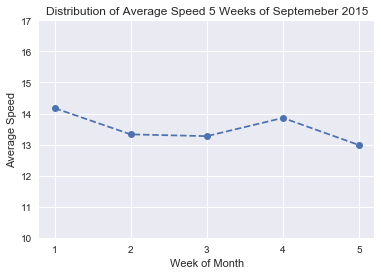

In [347]:
sns.set()
plt.plot('Week','Speed',data=week_data,marker='o',linestyle='--')
plt.xlabel('Week of Month')
plt.ylabel('Average Speed')
plt.title('Distribution of Average Speed 5 Weeks of Septemeber 2015')
plt.xticks(np.arange(1,6,step=1))
plt.yticks(np.arange(10,18,step=1))
plt.show()

#### Intent: Distribution of average trip speed as a function of time of day

In [346]:
speed_day=trip_data[['Speed','Pickup_Hour']]
speed_day=speed_day.groupby('Pickup_Hour',as_index=False)
speed_day=speed_day.aggregate(np.mean)
speed_day

,Pickup_Hour,Speed
0,0,15.082059
1,1,15.407533
2,2,15.752728
3,3,16.281710
4,4,18.107290
5,5,20.139802
6,6,18.275743
7,7,14.372578
8,8,12.667195
9,9,12.916633


#### Null Hypothesis H0: u0=u1=u2=u3...u21=u22=u23 (Average speeds for all hours of day is same)

#### Alternate Hypothesis H1: Average speeds for atleast two hours of day is different

In [348]:
pickup_hour_speed = []
for i in range(0,24):
    pickup_hour_speed.append(trip_data[trip_data['Pickup_Hour']==i]['Speed'])

stats.f_oneway(pickup_hour_speed[0],pickup_hour_speed[1],pickup_hour_speed[2],pickup_hour_speed[3],pickup_hour_speed[4],pickup_hour_speed[5],
              pickup_hour_speed[6],pickup_hour_speed[7],pickup_hour_speed[8],pickup_hour_speed[9],pickup_hour_speed[10],pickup_hour_speed[11],
              pickup_hour_speed[12],pickup_hour_speed[13],pickup_hour_speed[14],pickup_hour_speed[15],pickup_hour_speed[16],pickup_hour_speed[17],
              pickup_hour_speed[18],pickup_hour_speed[19],pickup_hour_speed[20],pickup_hour_speed[21],pickup_hour_speed[22],pickup_hour_speed[23])


F_onewayResult(statistic=2403.8254863281795, pvalue=0.0)

#### We observe that average speed increases from 12 at midnight till 5 AM and drops after that. This can be explained by the fact that at night, there is very little traffic, so the speed can be large. However,From 8 AM to 5 PM which are work hours, the speed is very less.

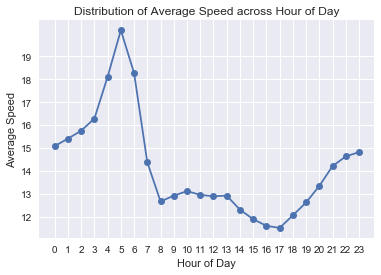

In [349]:
sns.set()
plt.plot('Pickup_Hour','Speed',data=speed_day,marker='o',linestyle='-')
plt.xlabel('Hour of Day')
plt.ylabel('Average Speed')
plt.title('Distribution of Average Speed across Hour of Day')
plt.xticks(np.arange(0,24,step=1))
plt.yticks(np.arange(12,20,step=1))
plt.show()